In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
sys.path.append('../examples')
sys.path.append('../jobs')
sys.path.append('../training_data')

from tqdm import trange

import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from generate_with_calibration import get_lookahead_entropies
from generate_with_entropy import sample_sequence, sample_sequence_batch, top_k_top_p_filtering

import logging
logging.getLogger('transformers.tokenization_utils').setLevel(logging.ERROR)

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


In [2]:
# setup cell

def set_seed(seed=42, n_gpu=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpus = torch.cuda.device_count()

set_seed()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(device)
model.eval()

vocab_size = tokenizer.vocab_size

01/07/2020 17:33:25 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /u/myhu/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.085d5f6a8e7812ea05ff0e6ed0645ab2e75d80387ad55c1ad9806ee70d272f80
01/07/2020 17:33:25 - INFO - transformers.configuration_utils -   Model config {
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "is_decoder": false,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torchscript": false,
  "use_bf

In [3]:
bins = list(range(-1, 50500, 500))
bins_2 = list(range(0, 50))

In [4]:
# the ground truth

# file = '../training_data/train.wp_h100'
# file = '../training_data/unicorn.txt'
file = '../training_data/gbw/training/news1-head100'

counts_ground_truth = []
with open(file) as fp:
    for line in fp:
        context = tokenizer.encode(line)
        
        N = len(context)
        
        for i in range(1, N):
            context_i = torch.tensor(context[:i], dtype=torch.long, device=device).unsqueeze(0)
    
            inputs = {'input_ids': context_i}
            outputs = model(**inputs)  
            model_next_logits = outputs[0][:, -1, :]
            next_probs = F.softmax(model_next_logits, dim=-1)[0].detach().cpu().numpy()
            
            next_word = context[i]
            rank = np.argsort(next_probs)[::-1]
            counts_ground_truth.append(np.argwhere(rank == next_word)[0][0]) # grossly inefficient but idc anymore

Text(0.5, 1.0, 'Gold label')

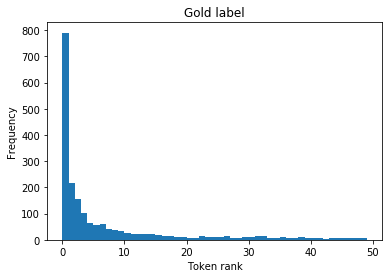

In [6]:
plt.hist(counts_ground_truth, bins_2)
plt.xlabel('Token rank')
plt.ylabel('Frequency')
plt.title('Gold label')

In [ ]:
# debugging cell

length=100
num_samples=1
temperature=1
top_k=0
top_p=0.9

ret = []
with open(file) as fp:
    for line in fp:
        context = tokenizer.encode(line)
        context = torch.tensor(context, dtype=torch.long, device=device)
        context = context.unsqueeze(0).repeat(num_samples, 1)
        generated = context

        with torch.no_grad():

            for gen_index in trange(length):

                inputs = {'input_ids': generated}

                outputs = model(**inputs)
                next_token_logits = outputs[0][:, -1, :] / temperature
                next_probs = F.softmax(next_token_logits, dim=-1)[0].detach().cpu().numpy()

                filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
                next_token = torch.multinomial(F.softmax(filtered_logits, dim=-1), num_samples=1)
                rank = np.argsort(next_probs)[::-1]
                ret.append(np.argwhere(rank == next_token.item())[0][0]) # grossly inefficient but idc anymore

                generated = torch.cat((generated, next_token), dim=1)

In [7]:
def get_counts(file, length=100, num_samples=1, temperature=1, top_k=0, top_p=0.0):
    ret = []
    with open(file) as fp:
        for line in fp:
            context = tokenizer.encode(line)
            context = torch.tensor(context, dtype=torch.long, device=device)
            context = context.unsqueeze(0).repeat(num_samples, 1)
            generated = context

            with torch.no_grad():

                for gen_index in trange(length):

                    inputs = {'input_ids': generated}

                    outputs = model(**inputs)
                    next_token_logits = outputs[0][:, -1, :] / temperature
                    next_probs = F.softmax(next_token_logits, dim=-1)[0].detach().cpu().numpy()

                    filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
                    next_token = torch.multinomial(F.softmax(filtered_logits, dim=-1), num_samples=1)
                    rank = np.argsort(next_probs)[::-1]
                    ret.append(np.argwhere(rank == next_token.item())[0][0]) # grossly inefficient but idc anymore

                    generated = torch.cat((generated, next_token), dim=1)
    return ret

In [5]:
#file = '../training_data/train.wp_h100'
#file = '../training_data/unicorn.txt'
file = '../training_data/gbw/training/news1-head100'

In [ ]:
counts_full = get_counts(file)

In [8]:
# some issue with nucleus sampling and CUDA. I'd much rather just avoid nucleus sampling altogether.
# I personally don't consider it a sampling method.

#counts_top_p = get_counts(file, top_p=0.9)
counts_top_k = get_counts(file, top_k=40)
counts_temp = get_counts(file, temperature=1)
counts_greedy = get_counts(file, top_k=1)

100%|██████████| 100/100 [00:02<00:00, 38.94it/s]


Text(0.5, 1.0, 'Top k = 40')

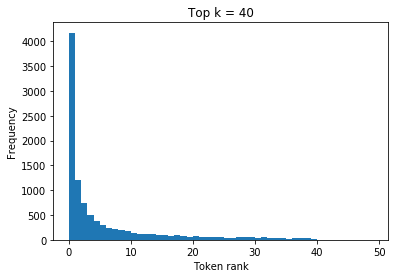

In [11]:
plt.hist(counts_top_k, bins_2)
plt.xlabel('Token rank')
plt.ylabel('Frequency')
plt.title('Top k = 40')

Text(0.5, 1.0, 'Temperature = 0.8')

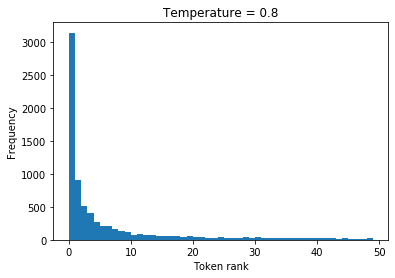

In [10]:
plt.hist(counts_temp, bins_2)
plt.xlabel('Token rank')
plt.ylabel('Frequency')
plt.title('Temperature = 0.8')

Text(0.5, 1.0, 'Greedy sampling')

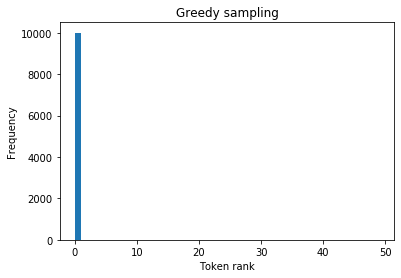

In [9]:
plt.hist(counts_greedy, bins_2)
plt.xlabel('Token rank')
plt.ylabel('Frequency')
plt.title('Greedy sampling')

In [19]:
# remember to load
np.savez('temp', ground_truth = counts_ground_truth, full=counts_full)

In [14]:
data = np.load('temp.npz')
counts_ground_truth = data['ground_truth']
counts_full = data['full']

In [15]:
np.savez('cache', 
        ground_truth = counts_ground_truth,
        top_k = counts_top_k,
        greedy = counts_greedy,
        full = counts_full,
        temp = counts_temp,
        bins1 = bins,
        bins2 = bins_2)